In [1]:
import numpy as np
import pandas as pd
import cPickle as cpkl
np.random.seed(42)

In [2]:
import matplotlib as mpl
# print(mpl.rcParams.items)
mpl.use('Agg')
mpl.rcParams['text.usetex'] = False
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = ['Times New Roman']
# mpl.rcParams['font.family'] = ['Times New Roman']
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['savefig.dpi'] = 250
mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['savefig.format'] = 'pdf'
mpl.rcParams['savefig.bbox'] = 'tight'
import matplotlib.pyplot as plt
%matplotlib inline
# print(mpl.rcParams.items)

import pylab
from mpl_toolkits.axes_grid1 import ImageGrid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

<!-- ![](./header.png) -->
<img src="./header.png",width=100%>

# The Photometric LSST Astronomical Time-series Classification Challenge (PLAsTiCC): Selection of a performance metric for classification probabilities

*Alex Malz (NYU)*, 
*Renee Hlozek (U. Toronto)*, 
*Tarek Alam (UCL)*, 
*Anita Bahmanyar (U. Toronto)*, 
*Rahul Biswas (Stockholm U.)*, 
*Emille Ishida (Clermont)*, 
*David Jones (Berkeley)*, 
*Ashish Mahabal (CfA)*, 
*Rafael Martinez-Galarza (Harvard)*, 
*Gautham Narayan (STScI)*,
*Christian Setzer (Stockholm U.)*

We describe and illustrate the process by which a global performance metric was chosen for Photometric LSST Astronomical Time-series Classification Challenge (PLAsTiCC), a Kaggle competition aiming to identify promising transient and variable classifiers for LSST by involving the broader community outside astronomy.

Introduction
============

The metric of this note is for the first version of the Kaggle competition, though there are future plans for an early classification challenge and identification of class-specific metrics for different science goals.  

* The metric must return a single scalar value.
* The metric must be well-defined for non-binary classes.
* The metric must balance diverse science use cases in the presence of heavily nonuniform class prevalence.
* The metric must respect the information content of probabilistic classifications.
* The metric must be able to evaluate deterministic classifications.
* The metric must be interpretable, meaning it gives a more optimal value for "good" mock classifiers and a less optimal value for mock classifiers plagued by anticipated systematic errors; in other words, it must pass basic tests of intuition.
* The metric must be reliable, giving consistent results for different instantiations of the same test case.

The Probabilistic Classification Metric (ProClaM) code used in this exploration of performance metrics is publicly available on [GitHub](https://github.com/aimalz/proclam).

In [3]:
import proclam
from proclam import *

Data
====

We confirm the behavior of the metrics on mock data with well-understood systematics as well as real data from past classification challenges.

## Mock classifier systematics

Controls
* agnostic: uniform probabilities across all classes
* perfect: perfectly accurate on all classes
* almost: a slight perturbation of the perfect classifier
* noisy: a large perturbation of the perfect classifier

Anticipated systematics
* tunnel vision: classifies one class well and others randomly
* cruise control: classifies all objects as a single class
* subsumed: consistently misclassifies one class as one other class

In [4]:
plasticc = {}
plasticc['label'] = 'ProClaM'
plasticc['names'] = []
plasticc['cm'] = {}
plasticc['delta'] = {}

In [5]:
M_classes = 13

In [6]:
# chosen = np.random.randint(0, M_classes)
chosen = 6
print(chosen)

6


In [7]:
def plot_cm_from_cm(cm, text):
    plt.imshow(cm.T, vmin=0., vmax=1., cmap='winter_r')
    plt.title(text)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.savefig('fig/'+text+'.png', bbox='tight', pad_inches=0.)
    
def wrap_up_classifier(cm, testname, info_dict, delta=0.1):
    cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
    cm = cm.T
    plot_cm_from_cm(cm, testname)
    info_dict = add_one_cm(info_dict, cm.T, testname, delta)
    return info_dict
        
def add_one_cm(info_dict, cm, testname, delta):
    info_dict['names'].append(testname)
    info_dict['cm'][testname] = cm
    info_dict['delta'][testname] = delta
    return info_dict

### Agnostic

Totally uniform CM

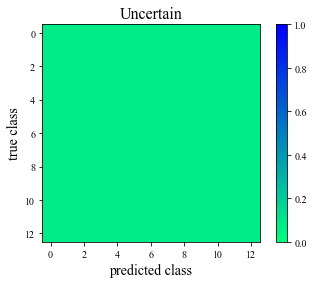

In [8]:
cm = np.ones((M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Uncertain', plasticc, delta=0.1)

### Perfect classifier

Identity matrix CM

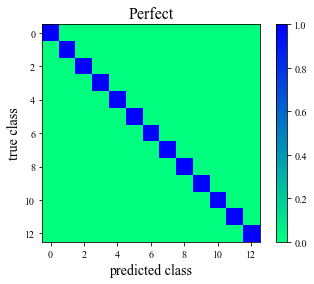

In [9]:
cm = np.eye(M_classes)
plasticc = wrap_up_classifier(cm, 'Perfect', plasticc, delta=0.1)

### Almost perfect classifier

Identity matrix CM plus low-amplitude uniform

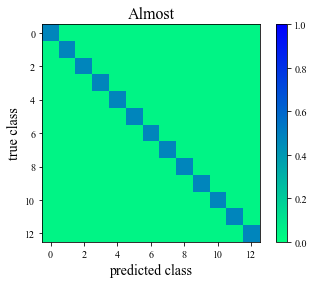

In [10]:
cm = np.eye(M_classes) + 0.1 * np.ones((M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Almost', plasticc, delta=0.1)

### Noisy classifier

Identity matrix CM plus high-amplitude uniform

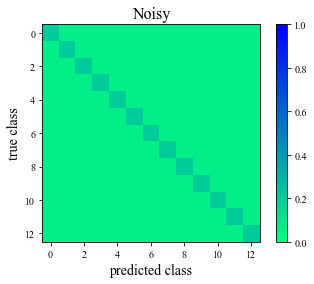

In [11]:
cm = np.eye(M_classes) + 0.5 * np.ones((M_classes, M_classes))
plasticc = wrap_up_classifier(cm, 'Noisy', plasticc, delta=0.1)

### Tunnel vision classifier

accurate predictions on one class and uniform on others

6


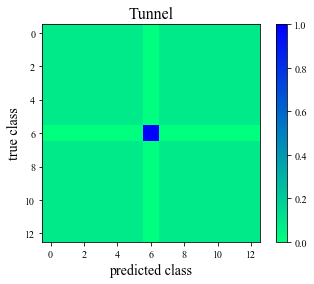

In [12]:
cm = np.ones((M_classes, M_classes))
cm = cm * np.asarray(0.1)[np.newaxis, np.newaxis]
print(chosen)
cm[chosen] = np.zeros((M_classes))
cm[:, chosen] = np.zeros((M_classes))#[np.newaxis, :]
cm[chosen][chosen] = 1.
plasticc = wrap_up_classifier(cm, 'Tunnel', plasticc, delta=0.1)

### Cruise control classifier

always predict one class regardless of true class

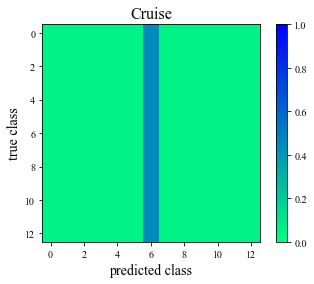

In [13]:
cm = np.ones((M_classes, M_classes))
cm = cm * 0.1
cm[:, chosen] = 1.
plasticc = wrap_up_classifier(cm, 'Cruise', plasticc, delta=0.1)

### Subsumed classifiers

Subsumed to: the chosen class is consistently misclassified as a different class

Subsumed from: another class is consistently misclassified as the chosen class

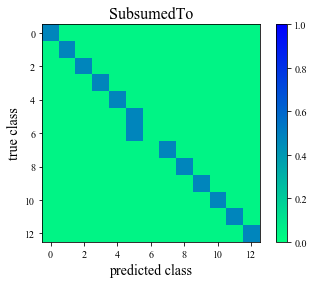

In [14]:
cm = plasticc['cm']['Almost'].copy()
cm[chosen] = cm[chosen-1]
plasticc = wrap_up_classifier(cm, 'SubsumedTo', plasticc, delta=0.1)

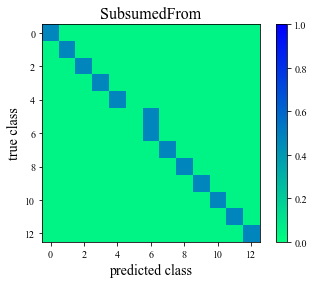

In [15]:
cm = plasticc['cm']['Almost'].copy()
cm[chosen-1] = cm[chosen]
plasticc = wrap_up_classifier(cm, 'SubsumedFrom', plasticc, delta=0.1)

In [16]:
def cm_mega_plot(info_dict, fn='', numrows=2, numcols=4):
    fig = pylab.figure(figsize=(10.1, 5.1))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,4),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.01,
                 )
    numrows=2
    numcols=4
    gridnos = np.arange(numrows * numcols).reshape((numcols, numrows)).T.flatten()
    for j in range(numcols * numrows):
        i = gridnos[j]
        ax = grid[j]#fig.add_subplot(numrows,numcols,i+1)#, frameon=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        position = ax.get_position()
#         print(position)
        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
#         print(position)
        testname = info_dict['names'][i]
        
        im = ax.imshow(info_dict['cm'][testname], vmin=0., vmax=1., cmap='winter_r')
        ax.text(.5,.9,testname,horizontalalignment='center',transform=ax.transAxes, fontsize=16)
#     pylab.colorbar()
#     fig.subplots_adjust(right=0.5)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    bigAxes.set_ylabel(r'true class', fontsize=20)
    bigAxes.set_xlabel(r'predicted class', fontsize=20)
    pylab.tight_layout()
    pylab.savefig('fig/all_'+fn+'_cm.png', bbox_inches='tight', pad_inches=0)

/home/aimalz/.local/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


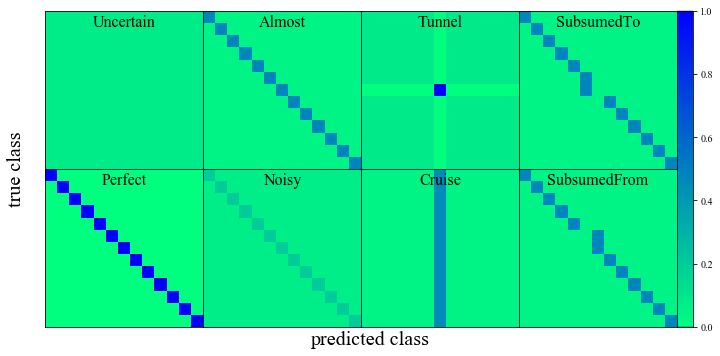

In [17]:
cm_mega_plot(plasticc, fn='sim')

### Combined mock systematics confusion matrix

In [ ]:
# afflicted = np.random.choice(range(0, M_classes), size=10, replace=False)
cruise = [0, 1]#afflicted[2:4]
subsumed = [2, 3, 5, 6]#afflicted[4:8]
tunnel = [4, 7]#afflicted[8:]
noisy_cls = [-2, -1]#afflicted[:2]
afflicted = cruise + subsumed + tunnel + noisy_cls

cm = plasticc['cm']['Almost'].copy()
cm[noisy_cls] = plasticc['cm']['Noisy'][noisy_cls]
cm[subsumed[:2]] = cm[cruise[0]]#[np.newaxis] + np.asarray(0.01)[np.newaxis] * np.random.uniform(M_classes)[np.newaxis, :]
cm[subsumed[2:]] = cm[cruise[1]]
cm[tunnel] = plasticc['cm']['Perfect'][tunnel]
# cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
plasticc = wrap_up_classifier(cm, 'Combined', plasticc, delta=0.01)
print(np.sum(plasticc['cm']['Combined'], axis=1))

## Real classification results

* SNPhotCC \[from Michelle?\]
* \[Ashish's data?\]
* Mystery \[Renee's data?\]

*show confusion matrices*

In [ ]:
# temporarily omitting real data
def plot_cm(probs, truth, text, loc=None):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    plt.matshow(cm.T, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1), names)
# plt.yticks(range(max(truth)+1), names)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.title(text)
#     plt.show()
    plt.savefig('fig/'+loc+'_cm.png')
    plt.close()

In [18]:
# temporarily omitting real data
# These are all functions for preprocessing Renee's data files.

def make_class_pairs(data_info_dict):
    for name in data_info_dict['names']:
        data_info_dict['class_pairs'][name] = [data_info_dict['classifications'][name], data_info_dict['truth_tables'][name]]
    return(data_info_dict['class_pairs'])
        
def make_file_locs(data_info_dict):
    data_info_dict['classifications'] = {}
    data_info_dict['truth_tables'] = {}
    data_info_dict['class_pairs'] = {}
    data_info_dict['probs'] = {}
    data_info_dict['truth'] = {}
    names = data_info_dict['names']
    data_info_dict['dirname'] = topdir + data_info_dict['label'] + '/'
    for name in names:
        data_info_dict['classifications'][name] = '%s/predicted_prob_%s.csv'%(name, name)
        data_info_dict['truth_tables'][name] = '%s/truth_table_%s.csv'%(name, name)
    return data_info_dict

def process_strings(dataset, cc):
    loc = dataset['dirname']
    text = dataset['label'] + '_' + dataset['names'][cc]
    return loc, text

# def plot_cm(probs, truth, text, loc=''):
#     cm = proclam.metrics.util.prob_to_cm(probs, truth)
#     plt.matshow(cm.T, vmin=0., vmax=1.)
#     plt.xlabel('predicted class')
#     plt.ylabel('true class')
#     plt.colorbar()
#     plt.title(text)
# #     plt.show()
#     plt.savefig(loc+'plot.png', dpi=250)
#     plt.close()

def plot_cm(probs, truth, text, loc=None):
    cm = proclam.metrics.util.prob_to_cm(probs, truth)
    plt.matshow(cm.T, vmin=0., vmax=1.)
# plt.xticks(range(max(truth)+1), names)
# plt.yticks(range(max(truth)+1), names)
    plt.xlabel('predicted class')
    plt.ylabel('true class')
    plt.colorbar()
    plt.title(text)
#     plt.show()
    saveloc = 'fig/'+text+'_cm.png'
#     print(saveloc)
    plt.savefig(saveloc)
    plt.show()
    plt.close()
    
def just_plot_cm(dataset, cc, pmat, tvec):
    fileloc, text = process_strings(dataset, cc)
    plot_cm(pmat, tvec, text, loc=dataset['label']+'_'+dataset['names'][cc])
    return

def just_read_class_pairs(pair, dataset, cc):
    loc, text = process_strings(dataset, cc)
    clfile = pair[0]
    truthfile = pair[1]
    prob_mat = pd.read_csv(loc + clfile, delim_whitespace=True).values
    nobj = np.shape(prob_mat)[0]
    nclass = np.shape(prob_mat)[1]
    truth_values = pd.read_csv(loc + truthfile, delim_whitespace=True).values
    nobj_truth = np.shape(truth_values)[0]
    nclass_truth = np.shape(truth_values)[1]
    tvec = np.where(truth_values==1)[1]
    pmat = prob_mat
    return pmat, tvec

def read_class_pairs(pair, dataset, cc):
    fileloc, text = process_strings(dataset, cc)
    pmat, tvec = just_read_class_pairs(pair, dataset, cc)
    filename = fileloc + dataset['names'][cc] + '/'
    plot_cm(pmat, tvec, text, loc=filename)
    return pmat, tvec

In [19]:
# temporarily omitting real data
topdir = '../examples/'
mystery = {}
mystery['cm'] = {}
mystery['label'] = 'Unknown'
mystery['names'] = ['RandomForest', 'KNeighbors', 'MLPNeuralNet']
# mystery['classifications'] = {}
# mystery['truth_tables'] = {}
# mystery['class_pairs'] = {}
# mystery['probs'] = {}
# mystery['truth'] = {}
mystery = make_file_locs(mystery)
mystery['class_pairs'] = make_class_pairs(mystery)

In [20]:
# temporarily omitting real data
snphotcc = {}
snphotcc['cm'] = {}
snphotcc['label'] = 'SNPhotCC'
prefixes = ['Templates', 'Wavelets']
suffixes = ['BoostForest', 'KNN', 'NB', 'NeuralNetwork', 'SVM']
snphotcc['names'] = []
for prefix in prefixes:
    for suffix in suffixes:
        snphotcc['names'].append(prefix+suffix)

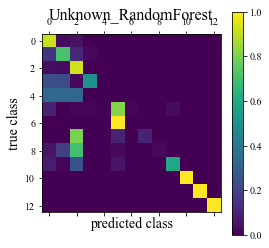

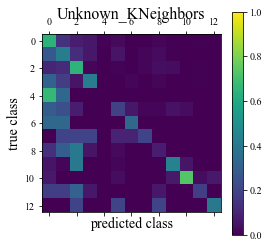

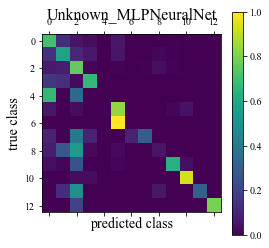

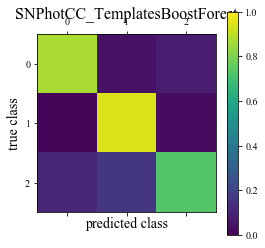

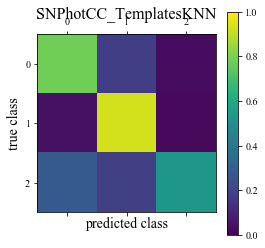

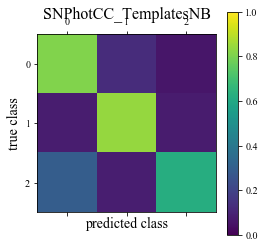

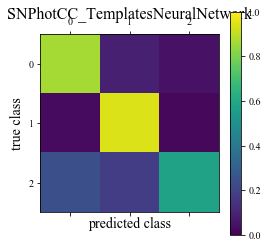

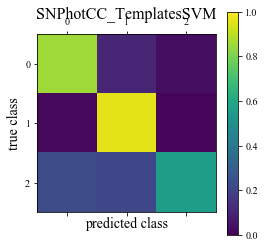

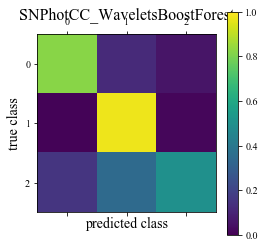

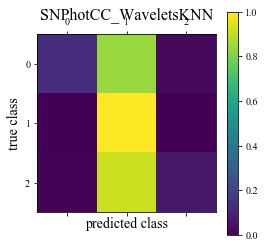

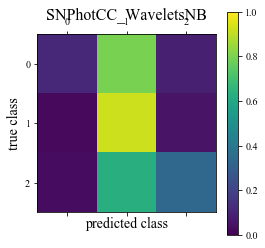

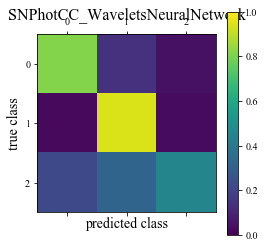

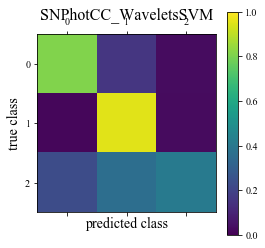

In [21]:
# temporarily omitting real data
topdir = '../examples/'
for dataset in [mystery, snphotcc]:
#     print(dataset['label'])
    dataset = make_file_locs(dataset)
    dataset['class_pairs'] = make_class_pairs(dataset)
    for nm, name in enumerate(dataset['names']):
        probm, truthv = read_class_pairs(dataset['class_pairs'][name], dataset, nm)
#         print(dataset['class_pairs'][name])
        dataset['probs'][name] = probm
        dataset['truth'][name] = truthv
        dataset['cm'][name] = proclam.metrics.util.prob_to_cm(probm, truthv)
#         plot_cm(probm, truthv, dataset['label']+'_'+name, loc=dataset['label']+'_'+name)

In [26]:
# temporarily omitting real data
def cm_mega_plot(info_dict, fn=''):
    numrows = 2
    numcols = 5
    fig = pylab.figure(figsize=(10.1, 5.1))
    bigAxes = pylab.axes(frameon=False)     # hide frame
    bigAxes.set_xticks([])                        # don't want to see any ticks on this axis
    bigAxes.set_yticks([])
    
    grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2,5),
                 axes_pad=0.,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="5%",
                 cbar_pad=0.01,
                 )
    gridnos = np.arange(numrows * numcols).reshape((numrows, numcols)).flatten()
    for j in range(numcols * numrows):
        i = gridnos[j]
        ax = grid[j]#fig.add_subplot(numrows,numcols,i+1)#, frameon=False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        position = ax.get_position()
#         print(position)
        position.x0 += 0.01
        position.y0 += 0.02
        position.x1 += 0.01
        position.y1 += 0.02
        ax.set_position(position)
#         print(position)
        testname = info_dict['names'][i]
        
        im = ax.imshow(info_dict['cm'][testname].T, vmin=0., vmax=1., cmap='winter_r')
        ax.text(.5,.1,testname,horizontalalignment='center',transform=ax.transAxes, fontsize=16)
#     pylab.colorbar()
#     fig.subplots_adjust(right=0.5)
#     cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
    ax.cax.colorbar(im)
    ax.cax.toggle_label(True)
    bigAxes.set_ylabel(r'true class', fontsize=20)
    bigAxes.set_xlabel(r'predicted class', fontsize=20)
    pylab.tight_layout()
    pylab.savefig('fig/all_'+fn+'_cm.png', bbox_inches='tight', pad_inches=0)

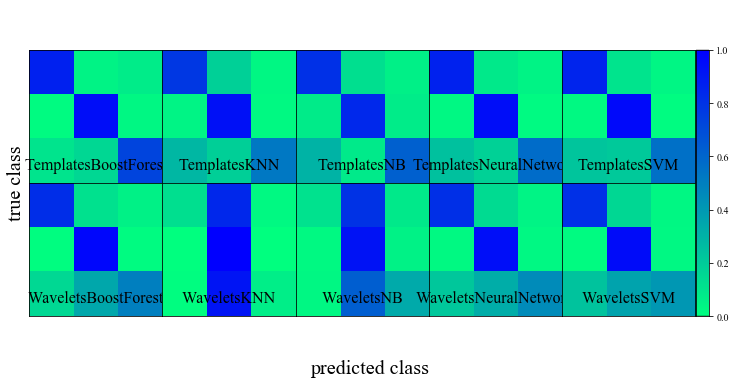

In [27]:
# temporarily omitting real data
cm_mega_plot(snphotcc, fn='snphotcc')

Methods (Metrics)
======

We considered two metrics of classification probabilities, each of which is interpretable and avoids reducing probabilities to point estimates

The Brier score is defined as
\begin{eqnarray*}
B &=& \sum_{m=1}^{M}\frac{w_{m}}{N_{m}}\sum_{n=1}^{N_{m}}\left((1-p_{n}(m | m))^{2}+\sum_{m'\neq m}^{M}(p_{n}(m' | m))^{2}\right)
\end{eqnarray*}

The log-loss is defined as
\begin{eqnarray*}
L &=& -\sum_{m=1}^{M}\frac{w_{m}}{N_{m}}\sum_{n=1}^{N_{m}}\ln[p_{n}(m | m)]
\end{eqnarray*}

We calculate the metric within each class $m$ by taking an average of its value $-\ln[p_{n}(m | m)]$ for each true member $n$ of the class.  Then we weight the metrics for each class by an arbitrary weight $w_{m}$ and take a weighted average of the per-class metrics to produce a global scalar metric.

In [ ]:
metricslist = ['Brier', 'LogLoss']
colors = [mpl.cm.winter_r(0.), mpl.cm.winter_r(1.)]
markerlist = ['s', 'o']

### Weights

We may take weighted averages of the per-class metrics, and these weights may be considered in terms of the systematics we discussed, by upweighting or downweighting the "chosen" class most affected by the systematics.

In [ ]:
chosen = {}
chosen['weights'] = {}
chosen['names'] = {'common': 0, 'rare': 4, 'subsumer': 5, 'subsumee': 6, 'invisible': 8}
ideas = chosen['names'].keys()
M_classes = 13

for idea in chosen['names'].keys():
    chosen['weights'][idea] = {}
    cc = chosen['names'][idea]
    flat_weight = np.ones(M_classes)
    hi_weight = np.ones(M_classes) / np.float(M_classes)
    hi_weight[cc] = 1.
    lo_weight = np.ones(M_classes) 
    lo_weight[cc] = 1. / np.float(M_classes)
    chosen['weights'][idea]['flat'] = flat_weight
    chosen['weights'][idea]['up'] = hi_weight
    chosen['weights'][idea]['down'] = lo_weight
    chosen['weights'][idea]['per_class'] = 'per_class'
    chosen['weights'][idea]['per_item'] = 'per_item'
    
schemes = ['flat', 'up', 'down', 'per_class', 'per_item']

Results
=======

*one plot per set of "true" classes: classifiers on x axis, metrics on y axes*

## Mock classifier systematics

In [ ]:
generator = proclam.simulators.LogUnbalanced()
N_objects = 1000000
truth = generator.simulate(M_classes, N_objects)
print(np.histogram(truth, bins=range(M_classes+1)))

In [ ]:
d = np.diff(np.unique(truth)).min()
left_of_first_bin = truth.min() - float(d)/2
right_of_last_bin = truth.max() + float(d)/2
plt.hist(truth, np.arange(left_of_first_bin, right_of_last_bin + d, d), log=True, alpha=0.5, color='k')
plt.xticks(range(max(truth)+1))
# plt.hist(truth, log=True, alpha=0.5)
plt.ylabel('counts')
plt.xlabel('class')
plt.savefig('fig/mock_counts.png')
plt.show()
plt.close()

In [ ]:
print(np.histogram(truth, bins=range(M_classes+1)))

In [ ]:
# data = np.empty((len(metricslist), len(plasticc['names'])))
plasticc['probs'] = {}
for cc, name in enumerate(plasticc['names']):
    code = proclam.classifiers.FromCM()
    probs = code.classify(plasticc['cm'][name], truth, delta=plasticc['delta'][name], other=False)
    plasticc['probs'][name] = probs
#     for count, metric in enumerate(metricslist):
#         D = getattr(proclam.metrics, metric)()
#         hm = D.evaluate(probs, truth, averaging='per_class')
#         data[count][cc] = hm
#     plasticc['probs'] = data

In [ ]:
# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
# def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
#     plot_n = n+1
#     in_x = np.arange(len(codes))
#     ax_n = ax
#     n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
#     handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
# #     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
#     return(ax, ax_n, handle)

# def metric_plot(dataset, res, metric_names, shapes, colors, modtext=''):
#     codes = dataset['names']
#     data = res
#     text = dataset['label']
# #     fileloc = dataset['dirname']+dataset['label']+'_results.png'
#     xs = np.arange(len(codes))
#     fig, ax = plt.subplots()
#     fig.subplots_adjust(right=1.)
#     handles = []
#     for n in range(len(metric_names)):
# #         print(np.shape(data[n]))
#         (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
#         handles.append(handle)
#     plt.xticks(xs, codes)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     plt.xlabel('Classifiers', fontsize=14)
#     plt.legend(handles, metric_names, loc='lower left')
#     fig.suptitle(text+modtext)
#     plt.savefig(text+modtext+'.png')
#     return

# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
    if plot_n>1:
        ax_n = ax.twinx()
        rot_ang = 270
        label_space = 15.
    else:
        rot_ang = 90
        label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
    ax_n.set_ylabel(metric_names[n], fontsize=14)#s, labelpad=label_space, rotation=rot_ang)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def multi_metric_plot(dataset, res, metric_names, shapes, colors, modtext='', fn='plot.png'):
    codes = dataset['names']
    data = res
    text = dataset['label']
#     fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
#         print(np.shape(data[n]))
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
#     plt.ylabel('LogLoss')
    plt.legend(handles, metric_names, loc='lower left')
    fig.suptitle(text+modtext)
#     plt.show()
    plt.savefig('fig/multi_metric_'+fn, dpi=250)
    plt.close()
    return

In [ ]:
print(afflicted)
# upweight most common
# under no systematics, cruise control, tunnel vision
per_item_tests = {}

cm = plasticc['cm']['Almost'].copy()
per_item_tests['Systematic-free'] = cm

cm = np.ones((M_classes, M_classes))
cm = cm * 0.1
cm[:, -1] = 1. 
per_item_tests['Cruise'] = cm


cruise = [0, 1]#afflicted[2:4]
subsumed = [2, 3, 5, 6]#afflicted[4:8]
tunnel = [4, 7]#afflicted[8:]
noisy_cls = [-2, -1]#afflicted[:2]
afflicted = cruise + subsumed + tunnel + noisy_cls

cm = plasticc['cm']['Almost'].copy()
cm[:, noisy_cls] = plasticc['cm']['Noisy'][:, noisy_cls]
cm[subsumed[:2]] = cm[cruise[0]]#[np.newaxis] + np.asarray(0.01)[np.newaxis] * np.random.uniform(M_classes)[np.newaxis, :]
cm[subsumed[2:]] = cm[cruise[1]]
cm[tunnel] = plasticc['cm']['Perfect'][tunnel]
# cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
plasticc = wrap_up_classifier(cm, 'Combined', plasticc, delta=0.01)
print(np.sum(plasticc['cm']['Combined'], axis=1))



In [ ]:
for wt in schemes:
    data = np.empty((len(metricslist), len(plasticc['names'])))
    for cc, name in enumerate(plasticc['names']):
        probs = plasticc['probs'][name]
        for count, metric in enumerate(metricslist):
            D = getattr(proclam.metrics, metric)()
            hm = D.evaluate(probs, truth, averaging=wt)
            data[count][cc] = hm
#     plasticc['results'] = data
    multi_metric_plot(plasticc, data, metricslist, markerlist, colors, 
                modtext=' '+wt+'weight', fn=wt+'.png')

In [ ]:
# generator = proclam.simulators.LogUnbalanced()
# minitruth = generator.simulate(M_classes, N_objects)
# minipops = np.histogram(minitruth, bins=range(M_classes+1))[0]/float(N_objects)
# classifier = proclam.classifiers.FromCM()

# minitest = {}
# which_affected = range(M_classes)
# systematic_info = {'agnostic':'s', 'tunnel':'o', 'almost':'+', 'noisy':'x', 'cruise':'d', 'subsumed':(3,0,0)}
# which_systematics = systematic_info.keys()#['agnostic', 'tunnel', 'almost', 'noisy', 'tunnel', 'cruise', 'subsumed']
# markerlist = systematic_info.values()#['', '', 'd', 'o', 'd', 's', (3,0,0)]

# minidelta = 0.1
# starter = np.eye(M_classes) + minidelta * np.ones((M_classes, M_classes))
# starter = starter / np.sum(starter, axis=1)[:, np.newaxis]

# which_weighted = ['by pop', 'flat', 'up', 'down']
# wt_const = 1. / float(M_classes)
    
# which_metrics = ['Brier', 'LogLoss']
# # markerlist = ['o', 'd', 's', (3,0,0)]#[['o', 'd', 's', (3,0,0)], ['.', 'x', '+', (3,1,90)]]

# def make_cm(start_cm, m, systematic):
#     # can wrap this in loop if systematic is a list
#     cm = start_cm
#     big_M = len(start_cm)
#     if systematic == 'agnostic':
#         cm[m] = np.ones(big_M)
#     if systematic == 'almost':
#         cm[m] = 0.5 * np.ones(big_M)
#         cm[m][m] += 1.5
#     if systematic == 'noisy':
#         cm[m] = 0.5 * np.ones(big_M)
#         cm[m][m] += 0.5
#     if systematic == 'tunnel' or systematic == 'perfect':
#         cm[m] = np.zeros(big_M)
#         cm[:, m] = np.zeros(big_M).T
#         cm[m][m] += 1.
#     if systematic == 'cruise' or systematic == 'subsumer':
#         cm[:, m] += 1.
#     if systematic == 'subsumed':
#         cm[m] = cm[m-1]
#     cm = cm / np.sum(cm, axis=1)[:, np.newaxis]
#     return cm

# def make_wv(m, wt_kw):
# #     wv = np.ones(M_classes)
#     if wt_kw == 'by pop':
#         wv = minipops
#     if wt_kw == 'flat': 
#         wv = np.ones(M_classes)
#     if wt_kw == 'up':
#         wv = np.ones(M_classes)
#         wv[m] += 1.
#     if wt_kw == 'down':
#         wv = np.ones(M_classes)
#         wv[m] /= 2.
#     wv = wv / np.sum(wv)
#     assert(np.isclose(np.sum(wv), 1.))
#     return wv

# miniweights = np.empty((len(which_weighted), M_classes, M_classes))
# for m in which_affected:
#     for wi in range(len(which_weighted)):
#         w = which_weighted[wi]
#         miniweights[wi][m] = make_wv(m, w)

# # for s in which_systematics:
# #     minitest[s] = {}
# #     for m in which_affected:
# #         minitest[s][str(m)] = {}
# #         minitest[s][str(m)]['cm'] = make_cm(starter, m, s)
# #         minitest[s][str(m)]['probs'] = classifier.classify(minitest[s][str(m)]['cm'], minitruth, 
# #                                                            delta=minidelta, other=False)
# #         minitest[s][str(m)]['results'] = {}
# #         for met in which_metrics:
# #             minitest[s][str(m)][met] = {}
# #             for wi in range(len(which_weighted)):
# #                 w = which_weighted[wi]
# #                 D = getattr(proclam.metrics, met)()
# #                 minitest[s][str(m)][met][w] = D.evaluate(minitest[s][str(m)]['probs'], minitruth, 
# #                                                          averaging=miniweights[wi][m])

In [ ]:
# for s in which_systematics:
#     minitest[s] = {}
#     for m in which_affected:
#         minitest[s][str(m)] = {}
#         minitest[s][str(m)]['cm'] = make_cm(starter, m, s)
#         minitest[s][str(m)]['probs'] = classifier.classify(minitest[s][str(m)]['cm'], minitruth, 
#                                                            delta=minidelta, other=False)
#         minitest[s][str(m)]['results'] = {}
#         for met in which_metrics:
#             minitest[s][str(m)][met] = {}
#             for wi in range(len(which_weighted)):
#                 w = which_weighted[wi]
#                 D = getattr(proclam.metrics, met)()
#                 minitest[s][str(m)][met][w] = D.evaluate(minitest[s][str(m)]['probs'], minitruth, 
#                                                          averaging=miniweights[wi][m])
#     print('finished '+s)
#     cpkl.dump(minitest[s], open(s+'_data.pkl', 'wb'))
#     print('saved '+s)

In [ ]:
# cpkl.dump(minitest, open('intermediatedata.pkl', 'wb'))

In [ ]:
# minitest = {}
# for s in which_systematics:
#     minitest[s] = cpkl.load(open(s+'_data.pkl', 'rb'))

In [ ]:
# def complete_metric_plot(dataset, metric_names, shapes):
    
#     systematics = dataset.keys()
#     xs = np.arange(len(systematics))
#     fig, ax = plt.subplots(figsize=(5,5))
    
#     ax.text(.3, .95, r'color$\sim \log[N_{m}]$', 
#             verticalalignment='center', transform=ax.transAxes, 
#             fontsize=10)
#     ax.text(.3, .9, r'size$\sim w_{m}$', 
#             verticalalignment='center', transform=ax.transAxes, 
#             fontsize=10)
#     fig.subplots_adjust(right=1.)
# #     handles = []
#     seeds = []
#     for m in which_affected:
#         one_seed = np.log10(max(1., N_objects * float(minipops[m]))) / 10.
#         seeds.append(one_seed)
#         for si in range(len(systematics)):
#             s = systematics[si]
#             for wi in range(len(which_weighted)):
#                 w = which_weighted[wi]
# #                 rel_wt = (np.average(miniweights[wi][m]) - miniweights[wi][m][m]) / np.average(miniweights[wi][m]) / 2. + 0.5
# #                 print(rel_wt)
#                 ax.scatter(dataset[s][str(m)][metric_names[0]][w], dataset[s][str(m)][metric_names[1]][w],
#                   c=mpl.cm.winter_r(one_seed),
#                   s=100.*miniweights[wi][m],
#                   marker=markerlist[si],
#                   alpha=0.25)
#     for si in range(len(systematics)):
#         ax.scatter(0., 0., c='k',
#                   marker=markerlist[si],
#                   alpha=0.25, label=systematics[si])
    
#     ax.set_xlabel(metric_names[0])
#     ax.set_ylabel(metric_names[1])
#     ax.set_ylim(0.95, 3.25)
#     ax.set_xlim(0.045, 0.085)
#     ax.legend(loc='lower right')
    
#     seeds = np.array(seeds)
#     print(seeds)
#     axins = inset_axes(ax,
#                     width="25%",  # width = 25% of parent_bbox width
#                     height="5%",  # height : 5%
#                     loc=2)
#     mpl.colorbar.ColorbarBase(axins, cmap=mpl.cm.winter_r,
#                                 norm=mpl.colors.Normalize(vmin=0., vmax=1.), 
#                               orientation='horizontal')
# #     axins.xaxis.set_ticks_position("top")
#     axins.xaxis.set_ticks(np.flip(seeds, axis=0))
#     axins.xaxis.set_ticklabels([]) #rotation=270, fontsize=10)
    
# #     plt.show()
#     plt.savefig('fig/all_effects_isolated.png', dpi=250)
#     plt.close()
#     return

In [ ]:
# # print(markerlist)
# complete_metric_plot(minitest, which_metrics, markerlist)

In [ ]:
# omitting real data for now
# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
# def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
#     plot_n = n+1
#     in_x = np.arange(len(codes))
#     ax_n = ax
#     n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
#     handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
# #     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
#     return(ax, ax_n, handle)

# def metric_plot(dataset, res, metric_names, shapes, colors, modtext=''):
#     codes = dataset['names']
#     data = res
#     text = dataset['label']
# #     fileloc = dataset['dirname']+dataset['label']+'_results.png'
#     xs = np.arange(len(codes))
#     fig, ax = plt.subplots()
#     fig.subplots_adjust(right=1.)
#     handles = []
#     for n in range(len(metric_names)):
# #         print(np.shape(data[n]))
#         (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
#         handles.append(handle)
#     plt.xticks(xs, codes)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     plt.xlabel('Classifiers', fontsize=14)
#     plt.legend(handles, metric_names, loc='lower left')
#     fig.suptitle(text+modtext)
#     plt.savefig(text+modtext+'.png')
#     return

# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], fontsize=14)#s, labelpad=label_space, rotation=rot_ang)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def systematic_metric_plot(dataset, res, metric_names, shapes, colors, modtext='', fn='plot.png'):
    codes = dataset['names']
    data = res
    text = dataset['label']
#     fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
#         print(np.shape(data[n]))
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
    plt.ylabel('LogLoss')
    plt.legend(handles, metric_names, loc='upper left')
    fig.suptitle(text+modtext)
#     plt.show()
    plt.savefig('fig/systematic_'+fn, dpi=250)
    plt.close()
    return

In [ ]:
# omitting real data for now
# loop over datasets, loop over 

data = np.empty((len(chosen['names'].keys()), len(schemes), len(mystery['names'])))
# data = np.empty((len(schemes), len(chosen['names'].keys()), len(mystery['names'])))

for cc, idea in enumerate(chosen['names'].keys()):
    for sc, scheme in enumerate(schemes):
# for sc, scheme in enumerate(schemes): 
#     for cc, idea in enumerate(chosen['names'].keys()):
        for nm, name in enumerate(mystery['names']):
            probm = mystery['probs'][name]
            truthv = mystery['truth'][name]
            D = getattr(proclam.metrics, 'LogLoss')()
            weighting = idea+' '+scheme
            hm = D.evaluate(prediction=probm, truth=truthv, averaging=chosen['weights'][idea][scheme])
            data[cc][sc][nm] = hm
#             data[sc][cc][nm] = hm
        print(weighting+': '+str(data[cc][sc]))
#         print(weighting+': '+str(data[sc][cc]))
    systematic_metric_plot(mystery, data[cc], schemes, markerlist, colors, 
                modtext=' '+idea+' weight', fn=mystery['label']+'_'+idea+'.png')
#     metric_plot(mystery, data[sc], list(ideas), markerlist, colors, modtext=' '+scheme+' weight', fn=scheme+'.png')

In [ ]:
# omitting real data for now
# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
# def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
#     plot_n = n+1
#     in_x = np.arange(len(codes))
#     ax_n = ax
#     n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
#     handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], rotation=rot_ang, fontsize=14, labelpad=label_space)
# #     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
#     return(ax, ax_n, handle)

# def metric_plot(dataset, res, metric_names, shapes, colors, modtext=''):
#     codes = dataset['names']
#     data = res
#     text = dataset['label']
# #     fileloc = dataset['dirname']+dataset['label']+'_results.png'
#     xs = np.arange(len(codes))
#     fig, ax = plt.subplots()
#     fig.subplots_adjust(right=1.)
#     handles = []
#     for n in range(len(metric_names)):
# #         print(np.shape(data[n]))
#         (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
#         handles.append(handle)
#     plt.xticks(xs, codes)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(90)
#     plt.xlabel('Classifiers', fontsize=14)
#     plt.legend(handles, metric_names, loc='lower left')
#     fig.suptitle(text+modtext)
#     plt.savefig(text+modtext+'.png')
#     return

# def make_patch_spines_invisible(ax):
#     ax.set_frame_on(True)
#     ax.patch.set_visible(False)
#     for sp in ax.spines.values():
#         sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
#     if plot_n>1:
#         ax_n = ax.twinx()
#         rot_ang = 270
#         label_space = 15.
#     else:
#         rot_ang = 90
#         label_space = 0.
#     if plot_n>2:
#         ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
#         make_patch_spines_invisible(ax_n)
#         ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
#     ax_n.set_ylabel(metric_names[n], fontsize=14)#s, labelpad=label_space, rotation=rot_ang)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def weightby_metric_plot(dataset, res, metric_names, shapes, colors, modtext='', fn='plot.png'):
    codes = dataset['names']
    data = res
    text = dataset['label']
#     fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
#         print(np.shape(data[n]))
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
    plt.ylabel('LogLoss')
    plt.legend(handles, metric_names, loc='upper left')
    fig.suptitle(text+modtext)
#     plt.show()
    plt.savefig('fig/weightby_'+fn, dpi=250)
    plt.close()
    return

In [ ]:
# omitting real data for now
# data = np.empty((len(chosen['names'].keys()), len(schemes), len(mystery['names'])))
data = np.empty((len(schemes), len(chosen['names'].keys()), len(mystery['names'])))

# for cc, idea in enumerate(chosen['names'].keys()):
#     for sc, scheme in enumerate(schemes):
for sc, scheme in enumerate(schemes): 
    for cc, idea in enumerate(chosen['names'].keys()):
        for nm, name in enumerate(mystery['names']):
            probm = mystery['probs'][name]
            truthv = mystery['truth'][name]
            D = getattr(proclam.metrics, 'LogLoss')()
            weighting = idea+' '+scheme
            hm = D.evaluate(prediction=probm, truth=truthv, averaging=chosen['weights'][idea][scheme])
#             data[cc][sc][nm] = hm
            data[sc][cc][nm] = hm
#         print(weighting+': '+str(data[cc][sc]))
        print(weighting+': '+str(data[sc][cc]))
#     metric_plot(mystery, data[cc], schemes, markerlist, colors, modtext=' '+idea+' weight', fn=idea+'.png')
    weightby_metric_plot(mystery, data[sc], list(ideas), markerlist, colors, 
                modtext=' '+scheme+' weight', fn=mystery['label']+'_'+scheme+'.png')

Would like to do this many times to generate error bars

Try with different weights relative to randomly chosen class

## Real classification results

In [ ]:
# temporarily omitting real data

def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)
        
def per_metric_helper(ax, n, data, metric_names, codes, shapes, colors):
    plot_n = n+1
    in_x = np.arange(len(codes))
    ax_n = ax
    n_factor = 0.1 * (plot_n - 2)
    if plot_n>1:
        ax_n = ax.twinx()
        rot_ang = 270
        label_space = 15.
    else:
        rot_ang = 90
        label_space = 0.
    if plot_n>2:
        ax_n.spines["right"].set_position(("axes", 1. + 0.1 * (plot_n-1)))
        make_patch_spines_invisible(ax_n)
        ax_n.spines["right"].set_visible(True)
    handle = ax_n.scatter(in_x+n_factor*np.ones_like(data[n]), data[n], marker=shapes[n], s=10, color=colors[n], label=metric_names[n])
    ax_n.set_ylabel(metric_names[n], fontsize=14, rotation=rot_ang)#s, labelpad=label_space, rotation=rot_ang)
#     ax_n.set_ylim(0.9 * min(data[n]), 1.1 * max(data[n]))
    return(ax, ax_n, handle)

def metric_plot(dataset, res, metric_names, shapes, colors, modtext='', fn='plot.png'):
    codes = dataset['names']
    data = res
    text = dataset['label']
#     fileloc = dataset['dirname']+dataset['label']+'_results.png'
    xs = np.arange(len(codes))
    fig, ax = plt.subplots()
    fig.subplots_adjust(right=1.)
    handles = []
    for n in range(len(metric_names)):
#         print(np.shape(data[n]))
        (ax, ax_n, handle) = per_metric_helper(ax, n, data, metric_names, codes, shapes, colors)
        handles.append(handle)
    plt.xticks(xs, codes)
    for tick in ax.get_xticklabels():
        tick.set_rotation(90)
    plt.xlabel('Classifiers', fontsize=14)
#     plt.ylabel('LogLoss')
    plt.legend(handles, metric_names, loc='upper left')
    fig.suptitle(text+modtext)
#     plt.show()
    plt.savefig('fig/'+fn, dpi=250)
    plt.close()
    return

In [ ]:
# temporarily excluding real data
for dataset in [mystery, snphotcc]:
    data = np.empty((len(metricslist), len(dataset['names'])))
    for cc, name in enumerate(dataset['class_pairs'].keys()):
        probm, truthv = read_class_pairs(dataset['class_pairs'][name], dataset, cc)
        for count, metric in enumerate(metricslist):
            D = getattr(proclam.metrics, metric)()
            hm = D.evaluate(probm, truthv)
            data[count][cc] = hm
#     dataset['results'] = data
    metric_plot(dataset, data, metricslist, markerlist, colors, fn=dataset['label']+'_res.png')

Conclusions
===========

We conclude that the Brier and log-loss metrics convey different information but are more or less consistent with our intuition for what makes a good classifier.  The Brier metric includes a penalty term not present in the log-loss but somehow is always consistent with the log-loss, meaning the penalty term doesn't really make a difference.  The log-loss has a larger dynamic range, which seems good but probably isn't that big a deal either.

Acknowledgments
===============

The DESC acknowledges ongoing support from the Institut National de Physique Nucleaire et de Physique des Particules in France; the Science & Technology Facilities Council in the United Kingdom; and the Department of Energy, the National Science Foundation, and the LSST Corporation in the United States.

DESC uses resources of the IN2P3 Computing Center (CC-IN2P3--Lyon/Villeurbanne - France) funded by the Centre National de la Recherche Scientifique; the National Energy Research Scientific Computing Center, a DOE Office of Science User Facility supported by the Office of Science of the U.S. Department of Energy under Contract No. DE-AC02-05CH11231; STFC DiRAC HPC Facilities, funded by UK BIS National E-infrastructure capital grants; and the UK particle physics grid, supported by the GridPP Collaboration.

This work was performed in part under DOE Contract DE-AC02-76SF00515.

Contributions
=======

Alex Malz: conceptualization, data curation, formal analysis, investigation, methodology, project administration, software, supervision, validation, visualization, writing - original draft

Renee Hlozek: data curation, formal analysis, funding acquisition, investigation, project administration, software, supervision, validation, visualization, writing - original draft

Tarek Alam: investigation, software, validation

Anita Bahmanyar: formal analysis, investigation, methodology, software, writing - original draft

Rahul Biswas: conceptualization, methodology, software

Emille Ishida: conceptualization, project administration, supervision

David Jones: software

Ashish Mahabal: data curation, software

Rafael Martinez-Galarza: data curation, software, visualization

Gautham Narayan: data curation, formal analysis

Christian Setzer: initial metric discussions/suggestions, software

In [ ]:
# cells with a tag of "hideme" will not appear in html resulting from:
# jupyter nbconvert desc_note/main.ipynb --TagRemovePreprocessor.remove_cell_tags='["hideme"]'
# jupyter nbconvert desc_note/main.ipynb --TagRemovePreprocessor.remove_input_tags='["hidein"]'
